# Header

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dog-breed-identification/"
arch=resnext101_64
bs=32

In [5]:
n = len(open(f'{PATH}labels.csv').readlines()) - 1
val_idxs = get_cv_idxs(n)

# Initial Exploration

In [ ]:
ls {PATH}

In [ ]:
labels = pd.read_csv(f'{PATH}/labels.csv')
labels.describe()

In [ ]:
pt = labels.pivot_table(index='breed', aggfunc=len)
pt.sort_values('id', ascending=False).hist()

In [ ]:
files = os.listdir(f'{PATH}train')
imsizes = [Image.open(f'{PATH}train/{fp}').size for fp in files]
imheight, imwidth = zip(*imsizes)

In [ ]:
plt.hist(imheight)

In [ ]:
plt.hist(imwidth)

In [ ]:
plt.imshow(plt.imread(f'{PATH}train/{files[0]}'))

# Model Fine Tuning

In [6]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',
                                        test_name='test', val_idxs=val_idxs,
                                        tfms=tfms, bs=bs, suffix='.jpg')

In [7]:
sz = 224
data = get_data(sz)

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

 84%|████████▎ | 214/256 [00:03<00:00, 69.27it/s, loss=10.7]


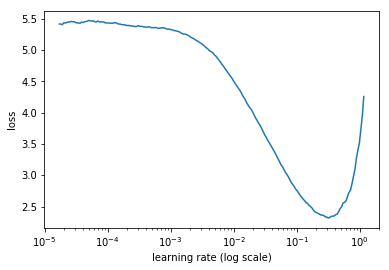

In [9]:
learn.lr_find()
learn.sched.plot()

In [10]:
lr = 5e-2

In [11]:
learn.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.682741   0.412692   0.892857  



[array([0.41269]), 0.8928571427404998]

In [12]:
learn.precompute = False
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.456077   0.247544   0.922211  
    1      0.364216   0.259362   0.920254                    



[array([0.25936]), 0.9202544027811861]

In [13]:
learn.save(f'{sz}')

In [14]:
sz = 299
data = get_data(299)

In [15]:
learn.set_data(get_data(299), precompute=True)

100%|██████████| 324/324 [02:49<00:00,  1.91it/s]


 80%|████████  | 205/256 [00:02<00:00, 79.36it/s, loss=1.16] 


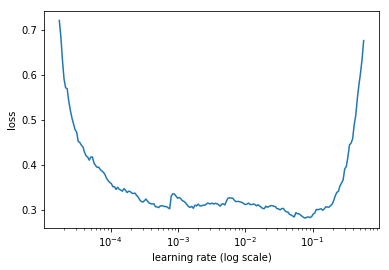

In [19]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 1e-4

In [20]:
learn.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.37805    0.335584   0.909491  



[array([0.33558]), 0.909491193621126]

In [21]:
learn.precompute = False
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.299634   0.223194   0.930039  
    1      0.294502   0.223936   0.931507                    



[array([0.22394]), 0.931506848965139]

In [23]:
learn.save(f'{sz}')

# Model Analysis

In [22]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [24]:
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9319960861056752, 0.20641340023995788)

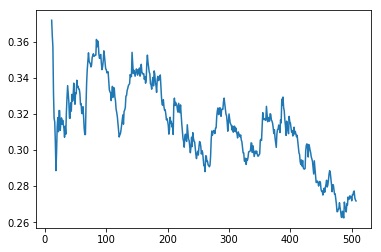

In [25]:
learn.sched.plot_loss()

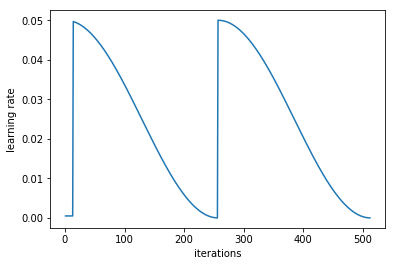

In [26]:
learn.sched.plot_lr()

# Submission

In [27]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [28]:
ds = pd.DataFrame(probs)
ds.columns = data.classes

In [29]:
ds.insert(0, 'id', [fname[5:-4] for fname in data.test_ds.fnames])

In [30]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
ds.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [31]:
FileLink(f'{SUBM}subm.gz')

/home/paperspace/fastai/courses/dl1/data/dog-breed-identification/subm/subm.gz

# Individual Prediction

In [ ]:
fn = data.val_ds.fnames[0]

In [ ]:
Image.open(f'{PATH}{fn}').resize((150, 150))

In [ ]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [ ]:
im = val_tfms(plt.imread(f'{PATH}{fn}'))
preds = learn.predict_array(im[None])
np.argmax(preds)